# Treinando um modelo de linguagem Transformer do zero em partidas anotadas de xadrez


### Preparando o ambiente

Biblioteca python-chess (https://python-chess.readthedocs.io/en/latest/).

In [ ]:
!pip uninstall python-chess -y
!pip install python-chess --upgrade

Engine de Xadrez *Stockfish* (https://stockfishchess.org/).

In [ ]:
stockfish_path = '/usr/games/stockfish'
!apt install stockfish

In [3]:
import chess
import chess.pgn as pgn
import chess.svg
import io
import random
import numpy as np
from copy import copy

In [4]:
chess.__version__

'1.9.2'

## 1. Treinando o *tokenizer*

O vocabulário de escolha do presente notebook são as possíveis anotações de lances do formato PGN. Ao todo são mais de 14700 palavras que representam lances (ex: e4, Nf3, c5, d4xe5, e8=Q, etc.).

Antes é preciso instalar as bibliotecas *transformers* e *tokenizers* da Huggingface (https://huggingface.co/).


In [ ]:
!pip uninstall -y tensorflow
!pip install git+https://github.com/huggingface/transformers
!pip list | grep -E 'transformers|tokenizers'

Daí montamos a pasta do Google Drive, que guardará os arquivos de treinamento do modelo e do tokenizer, além da nossa base de partidas.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Para treinar o tokenizer, especificaremos o nosso vocabulário a partir de um arquivo que contém todos os tokens possíveis. Passaremos a lista consistindo desses tokens como tokens especiais e passeremos um caminho de arquivo qualquer com poucas anotações de partidas apenas para preencher o argumento de treino do tokenizer.

In [7]:
%%time 
from pathlib import Path

from tokenizers import Tokenizer
from tokenizers.models import Unigram
from tokenizers.pre_tokenizers import Whitespace

base_dir = '/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks'
paths = ['/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/MacKenzie.pgn_simplified.spgn',
         '/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/twic1431g/twic1431.pgn_simplified.spgn']

tokenizer = Tokenizer(Unigram())
tokenizer.pre_tokenizer = Whitespace()

with open(f'{base_dir}/complete_vocab.txt', 'r') as f:
  vocab = f.read().split('\n')

vocab += ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]
# Remove +, #, and =QRBN

# tokenizer.train(files=paths, vocab_size=len(vocab), min_frequency=1, special_tokens=vocab)
from tokenizers.trainers import UnigramTrainer
trainer = UnigramTrainer(vocab_size=len(vocab), special_tokens=vocab)
tokenizer.train(files=paths, trainer=trainer)

CPU times: user 1.04 s, sys: 1.15 s, total: 2.19 s
Wall time: 2.03 s


Abaixo segue um exemplo de tokenização de uma entrada representando um começo de partida de xadrez.

In [ ]:
# output = tokenizer.encode("e4 e5 Nf3 Nf6 d4 Nxe4 Bd3 d5 dxe5")
# print(output.tokens)
# print(len(vocab))

Salvaremos o tokenizer no nosso diretório principal, especificado pela variável **model_dir**.

In [8]:
model_dir = "/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnGPT"
# tokenizer.model.save(model_dir)
# tokenizer.save(f"{model_dir}/tokenizer.json")

In [ ]:
# # from tokenizers.implementations import ByteLevelBPETokenizer
# # from tokenizers.implementations import Tokenizer
# from tokenizers.processors import BertProcessing


# # tokenizer = ByteLevelBPETokenizer(
# #     "./pgnBERT/vocab.json",
# #     "./pgnBERT/merges.txt",
# # )
# tokenizer = Tokenizer.from_file(
#     f"{model_dir}/tokenizer.json"
# )

# # print(tokenizer.pad_token)
# # tokenizer.mask_token = "<mask>"

In [ ]:
# tokenizer._tokenizer.post_processor = BertProcessing(
#     ("</s>", tokenizer.token_to_id("</s>")),
#     ("<s>", tokenizer.token_to_id("<s>")),
# )
# tokenizer.enable_truncation(max_length=512)

In [ ]:
# tokenizer.encode("e4 e5 Nf3 Nf6 d4")
# tokenizer.encode("e4 e5 Nf3 Nf6 d4").tokens

## 2. Treinando o modelo de linguagem

Poderemos treinar um *Masked Language Model* (MLM), tais como BERT e derivados, ou um *Causal Language Model* (CLM), tais como GPT. Pouca coisa muda quando usamos as bibliotecas da Huggingface.

A seguir treinamos uma versão da arquitetura GPT-2 do zero.

Primeiro, veremos se a GPU está disponível.

In [9]:
!nvidia-smi

Mon Jul  4 19:29:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
import torch
torch.cuda.is_available()

True

Agora definiremos a configuração do modelo. 15005 é o tamanho do vocabulário mais alguns tokens especiais.

In [11]:
# from transformers import RobertaConfig

# RoBERTa:
# config = RobertaConfig(
#     vocab_size=15011,
#     max_position_embeddings=514,
#     num_attention_heads=12,
#     num_hidden_layers=6,
#     type_vocab_size=1,
# )

# GPT-2:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config(
    vocab_size=15005
)

O tokenizer treinado e salvo anteriormente será carregado na forma de um GPT2TokenizerFast.

In [12]:
# from transformers import RobertaTokenizerFast

# RoBERTa:
# tokenizer = RobertaTokenizerFast.from_pretrained(model_dir, max_len=512)

# GPT-2:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained(model_dir, max_len=512)
print(tokenizer.mask_token)

<mask>


Da primeira vez que o código é executado, o tokenizer ainda não possui alguns dos tokens especiais (BOS, EOS, PAD, UNK e MASK). Daí é preciso descomentar e executar a célula a seguir, que adiciona os novos tokens ao tokenizer.

In [ ]:
# tokenizer.bos_token = "<s>"
# tokenizer.pad_token = "<pad>"
# tokenizer.eos_token = "</s>"
# tokenizer.unk_token = "<unk>"
# tokenizer.mask_token = "<mask>"
# tokenizer.save_pretrained(model_dir)

Agora inicializeremos o modelo.

É importante destacar que não inicializaremos o modelo a partir de um treinado em linguagem natural, pois nosso objetivo é treinar nas partidas de xadrez em formato PGN.

Na primeira execução, é preciso descomentar e executar a célula abaixo.

In [ ]:
# from transformers import RobertaForMaskedLM

# Para RoBERTa:
# model = RobertaForMaskedLM(config=config)

# Para GPT-2:
# model = GPT2LMHeadModel(config=configuration)

Caso o modelo já tenha sido treinado e salvo, é possível carregá-lo:

In [13]:
# from transformers import RobertaForMaskedLM

# RoBERTa:
# model = RobertaForMaskedLM.from_pretrained("/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT")

# GPT-2:
model = GPT2LMHeadModel.from_pretrained(model_dir)

print(model.num_parameters())

97366272


### Criando o Dataset de treino

Precisaremos definir a nossa própria classe de dataset herdando da classe Dataset do PyTorch. Faremos isso por questões de escalabilidade, visto que usar um LineByLineTextDataset requer que um arquivo com todas as partidas seja carregado inteiro na memória.

O nosso CustomTextDataset lê as partidas de uma forma diferente: todas as partidas são distribuídas em 2000 arquivos, de modo que em um dado momento apenas parte das partidas precisa estar na memória.

In [14]:
positioning = "a2 a7 b2 b7 c2 c7 d2 d7 e2 e7 f2 f7 g2 g7 h2 h7"
positioning += " Ra1 Ra8 Nb1 Nb8 Bc1 Bc8 Qd1 Qd8 Ke1 Ke8 Bf1 Bf8 Ng1 Ng8 Rh1 Rh8"
pos_set = set(positioning.split(" "))

In [ ]:
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizer
from typing import Dict
from glob import glob
from functools import lru_cache
import os

class CustomTextDataset(Dataset):
  def __init__(self, tokenizer: PreTrainedTokenizer, dir_path: str, block_size: int):
    if not os.path.isdir(dir_path):
      raise ValueError(f"Input dir path {dir_path} not found")
    self._tokenizer = tokenizer
    self._block_size = block_size
    file_paths = glob(dir_path + "/*")
    self._dir_path = dir_path
    self._shard_len = 1000
    self._len = 0
    for file_path in file_paths:
      with open(file_path, encoding="utf-8") as f:
        self._len += sum(1 for line in f if len(line) > 2)
    self._mem = {}
    self._positioning = positioning
    print(self._len)

  def __len__(self):
    return self._len

  def __getitem__(self, i) -> Dict[str, torch.tensor]:
    if i in self._mem:
      return self._mem[i]

    shard = i // self._shard_len
    eg = i % self._shard_len
    fname = f'{self._dir_path}/{shard}.cpgn'

    lines = []
    with open(fname, encoding="utf-8") as f:
      for idx, line in enumerate(f):
        if len(line) > 2:
          line = [tok for tok in line.split(' ') if len(tok) > 0 and not tok.isspace()]
          for ch in '+#=':
            line = [tok.split(ch)[0] for tok in line]
          line = ' '.join(line)
          lines.append(f"{self._positioning} {line}")

    batch_encoding = self._tokenizer(
        lines,
        add_special_tokens=True,
        truncation=True,
        max_length=self._block_size
    )
    examples = batch_encoding["input_ids"]
    examples = [{"input_ids": torch.tensor(e, dtype=torch.long)} for e in examples]

    for idx in range(len(examples)):
      self._mem[shard * self._shard_len + idx] = examples[idx]

    return examples[eg]

In [ ]:
%%time
# from transformers import LineByLineTextDataset

# dataset = LineByLineTextDataset(
#     tokenizer=tokenizer,
#     file_path="/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/clean_joint_100.cpgn",
#     block_size=128,
# )

dataset = CustomTextDataset(
    tokenizer=tokenizer,
    dir_path="/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/cpgn",
    block_size=128,
)

1820744
CPU times: user 1.59 s, sys: 488 ms, total: 2.08 s
Wall time: 1min 2s


O data collator será usado na criação de batches de treino.

In [ ]:
from transformers import DataCollatorForLanguageModeling

# RoBERTa:
# data_collator = DataCollatorForLanguageModeling(
#     tokenizer=tokenizer, mlm=True, mlm_probability=0.15
# )

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

Agora inicializaremos nosso objeto Trainer, que é responsável pelo treino do modelo. O objeto TrainingArguments é usado para especificar parâmetros do treino como diretório de saída, número de épocas, tamanho do batch e outros.

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=model_dir,
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_gpu_train_batch_size=32,
    save_steps=5000,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


Agora iniciaremos o treino propriamente dito.

In [ ]:
%%time
trainer.train()

Salvaremos o modelo no nosso diretório para que possa ser carregado e usado depois, tanto para continuar o treino quanto para fazer inferência.

In [ ]:
trainer.save_model(model_dir)

Saving model checkpoint to /content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnGPT
Configuration saved in /content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnGPT/config.json
Model weights saved in /content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnGPT/pytorch_model.bin


## 3. Usando o modelo treinado

Quando usamos um CLM, a parte generativa (decoder) retorna a probabilidade de cada palavra no vocabulário dadas as palavras anteriores (prompt). A seguir usaremos os escores da saída do método **generate** para criar partidas baseadas em diferentes estratégias de amostragem. A mais simples delas é a *greedy*, onde cada novo token é gerado e concatenado aos últimos. Outra forma de amostrar sequências de tokens consiste em pegar os próximos *k* tokens com maior probabilidade conjunta (dados os anteriores). O caso onde *k = 1* equivale ao greedy.

Primeiro instalaremos a biblioteca python-chess, que será útil para validar as saídas do modelo, de modo que apenas partidas válidas sejam geradas.

Agora definiremos alguns métodos auxiliares e métodos para as diferentes técnicas de amostragem citadas.

In [15]:
game_end = ['1-0', '0-1', '1/2-1/2']

def is_legal(board, move):
  try:
    board.push_san(move)
    board.pop()
  except ValueError as e:
    return False
  return True

def gen_next_greedy(prompt, prob_mass=0.7, random_seed=0, limit=None):
  prompt = f"{positioning} {prompt}"
  input_ids = tokenizer(prompt, return_tensors="pt")
  input_ids = input_ids.input_ids
  input_ids = input_ids.to(model.device)
  outputs = model.generate(
      input_ids,
      do_sample=False,
      max_length=len(input_ids[0]) + 1,
      output_scores=True,
      return_dict_in_generate=True,
      pad_token_id=tokenizer.eos_token_id
  )
  scores = outputs.scores[0].detach().cpu().numpy()[0]
  prob_scores = np.exp(scores) / sum(np.exp(scores))
  next_ids = np.argsort(scores)
  if limit:
    next_ids = next_ids[-limit:]
  acc_prob = 0.0
  top_ids = []
  for idx in range(len(next_ids) - 1, -1, -1):
    if acc_prob >= prob_mass and len(top_ids) > 0:
      break
    acc_prob += prob_scores[next_ids[idx]]
    top_ids.append(next_ids[idx])
  top_scores = prob_scores[top_ids]
  outputs = tokenizer.batch_decode(torch.tensor([top_ids], device=model.device))
  outputs = outputs[0]
  ans = {'tokens': outputs.split(' '), 'probabilities': top_scores}
  paired = {}
  for tok, prob in zip(ans['tokens'], ans['probabilities']):
    paired[tok] = prob
  ans['paired'] = paired
  return ans

def _generate_best_next(
    board,
    prompt,
    k=4,
    prob_mass=0.7,
    stochastic=False,
  ):
  moves = gen_next_greedy(prompt, prob_mass, limit=10)
  moves, probs, pairs = moves['tokens'], moves['probabilities'], moves['paired']
  if k <= 1:
    idx = 0
    legal_moves = []
    while idx < len(moves):
      if is_legal(board, moves[idx]):
        legal_moves.append((probs[idx], moves[idx]))
      if len(legal_moves) == 2:
        break
      idx += 1
    if len(legal_moves) > 0:
      if stochastic and (np.random.randint(0, 2) == 1):
        move_idx = np.random.choice(list(range(len(legal_moves[:2]))), 1)[0]
        move = legal_moves[move_idx]
      else:
        move = legal_moves[0]
      prob, move = move
      return np.log(prob), move
    else:
      return float('-inf'), ''
  max_score = float('-inf')
  max_moves = None
  for move in board.legal_moves:
    move = board.san(move)
    if move in pairs:
      prob = pairs[move]
      board.push_san(move)
      sub_score, sub_moves = _generate_best_next(
          board,
          prompt + ' ' + move,
          k - 1,
          prob_mass,
          stochastic
      )
      board.pop()
      curr_score = np.log(prob) + sub_score
      if curr_score > max_score:
        max_score = curr_score
        if len(sub_moves) > 0:
          max_moves = move + ' ' + sub_moves
        else:
          max_moves = move
  if max_moves is None:
    return float('-inf'), ''
  return max_score, max_moves

No método **generate_game**, o argumento *start* informa quais os lances jogados inicialmente e deve conter pelo menos um lance. *lookahead* controla o número de lances da profundidade na amostragem. *stochastic* informa se a geração deve ser aleatória ou determinística.

In [16]:
def generate_game(
    start='e4',
    lookahead=1,
    stochastic=False,
  ):
  max_moves = 100
  num_iter = max_moves // lookahead
  print(start, end=' ')
  board = chess.Board()
  for move in start.split(' '):
    if len(move) > 0:
      board.push_san(move)
  for _ in range(num_iter):
    new_moves = _generate_best_next(
        board,
        start,
        k=lookahead,
        prob_mass=0.99,
        stochastic=stochastic
    )[1]
    if len(new_moves) == 0:
      break
    for move in new_moves.split(' '):
      if len(move) > 0:
        board.push_san(move)
    print(new_moves, end=' ')
    start += ' ' + new_moves
  print()
  return start

In [ ]:
generate_game(lookahead=3, stochastic=True)

e4 c5 Nf3 d6 d4 cxd4 Qxd4 Nc6 Bb5 Bd7 Bxc6 Bxc6 c4 Nf6 Nc3 g6 O-O Bg7 h3 O-O Qd3 Nd7 Be3 Nc5 Qc2 a5 Rad1 a4 Nd4 Qa5 Nxc6 bxc6 Bd4 Bxd4 Rxd4 Rfb8 Rfd1 Rb4 Qe2 Rab8 e5 dxe5 Qxe5 Qb6 Nxa4 Nxa4 Qxe7 Rxb2 Rd8 Kg7 Rxb8 Qxb8 Rd7 Kg8 Rd8 Kg7 Rd7 Kg8 Qf6 Qe8 Rd8 Rb8 Rxb8 Qxb8 Qxc6 Qa7 Qc8 Kg7 c5 h5 c6 h4 c7 Qb6 Qd7 Kf6 Qc8 Kg7 Qd7 Kf6 Qd2 Kg7 Qd7 Kf6 Qd8 Kg7 Qd7 Kf6 Qd2 Kg7 Qd7 Kf6 Qd2 Kg7 Qd7 Kf6 Qd8 Kg7 Qd7 Kg8 


'e4 c5 Nf3 d6 d4 cxd4 Qxd4 Nc6 Bb5 Bd7 Bxc6 Bxc6 c4 Nf6 Nc3 g6 O-O Bg7 h3 O-O Qd3 Nd7 Be3 Nc5 Qc2 a5 Rad1 a4 Nd4 Qa5 Nxc6 bxc6 Bd4 Bxd4 Rxd4 Rfb8 Rfd1 Rb4 Qe2 Rab8 e5 dxe5 Qxe5 Qb6 Nxa4 Nxa4 Qxe7 Rxb2 Rd8 Kg7 Rxb8 Qxb8 Rd7 Kg8 Rd8 Kg7 Rd7 Kg8 Qf6 Qe8 Rd8 Rb8 Rxb8 Qxb8 Qxc6 Qa7 Qc8 Kg7 c5 h5 c6 h4 c7 Qb6 Qd7 Kf6 Qc8 Kg7 Qd7 Kf6 Qd2 Kg7 Qd7 Kf6 Qd8 Kg7 Qd7 Kf6 Qd2 Kg7 Qd7 Kf6 Qd2 Kg7 Qd7 Kf6 Qd8 Kg7 Qd7 Kg8'

Também podemos jogar contra o modelo:

In [ ]:
start = ''
num_moves = 200
k = 1
num_iter = num_moves // k
for idx in range(num_iter):
  if idx % 2 == 0:
    start += f' {input()}'
  else:
    new_moves = _generate_best_next(start, k=k, prob_mass=0.999)[1]
    print(new_moves)
    start += ' ' + new_moves
# print(start)

# print(generate_greedy(start, stochastic=True))

## 4. Avaliação quantitativa usando Stockfish

In [17]:
from matplotlib import pyplot as plt

Abaixo definimos métodos para avaliar uma dada partida usando a *engine* Stockfish. Contrário ao que se pensava na segunda entrega do trabalho, é a Stockfish é open-source e pode ser instalada e usada gratuitamente. A Stockfish é uma das melhores engines de Xadrez em uso na atualidade.

A avaliação de uma partida consiste da sequência dos escores de cada uma das suas posições, na ordem das jogadas. O escore de uma posição é medido em "centi-peões", o que significa que um valor de 100 equivale a uma vantagem média de um peão. Um escore positivo significa posição melhor para as peças brancas, enquanto que um escore negativo significa uma posição melhor para as peças pretas.

In [18]:
def process_score(info):
  score_limit = 1000
  score = info['score'].white().score()
  if info['score'].white().mate() is not None:
    if info['score'].white().mate() < 0:
      score = -score_limit
    else:
      score = score_limit
  score = max(min(score, score_limit), -score_limit)
  return score

def eval_game(game):
  engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)
  board = chess.Board()
  timeout = 0.1
  scores = []
  for move in game.split(' '):
    if (len(move) < 2
        or (move in game_end)
        or not is_legal(board, move)
      ):
      continue
    board.push_san(move)
    info = engine.analyse(board, chess.engine.Limit(time=timeout))
    scores.append(process_score(info))
  return scores

Podemos avaliar as posições de um jogo e plotar o gráfico da partida para fins de visualização:

In [76]:
scores = eval_game(generate_game())

e4 c5 Nf3 d6 d4 cxd4 Nxd4 Nf6 Nc3 a6 Be3 e5 Nb3 Be6 f3 h5 Qd2 Nbd7 O-O-O Rc8 Kb1 Be7 Be2 b5 Nd5 Bxd5 exd5 Nb6 Bxb6 Qxb6 f4 O-O fxe5 dxe5 Rhf1 e4 Nd4 e3 Qd3 g6 Bf3 Rc4 Nc6 Qc5 Nxe7 Qxe7 d6 Qd7 Bd5 Nxd5 Qxd5 Rxc2 Ka1 Rfc8 h3 Kg7 a3 a5 Rd3 b4 axb4 axb4 Rb3 Rb8 Qe5 Kh7 Qd5 Rc5 Qe4 f5 Qd5 Kg7 Qd4 Kh7 Rxb4 Rxb4 Qxb4 Rb5 Qd4 Qc6 Rc1 Qxd6 Rd1 Qe5 Qxe5 Rxe5 b4 g5 b5 g4 b6 f4 b7 Kg7 hxg4 hxg4 Rc1 Rc5 Re1 Kf6 Rc1 


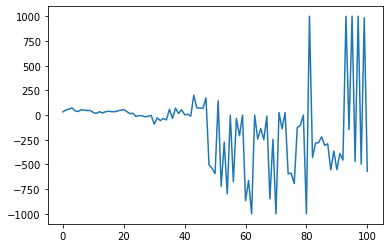

In [77]:
plt.plot(scores)

### Geração das partidas para avaliação

Nossa geração de partidas possui três parâmetros principais:

*   O tamanho do *lookahead* na busca por jogadas, sendo 1, 2 ou 3.
*   O lance inicial (*start*) das peças brancas, sendo "e4", "d4", "c4" ou "Nf3".
*   O número de repetições dados os parâmetros acima. Esse valor é igual a 10.

As partidas são salvas em arquivos separados numa pasta no Google Drive.

In [ ]:
# Generate games
all_games = []
for lookahead in [1, 2, 3]:
  for idx in range(10):
    for start in ['e4', 'd4', 'c4', 'Nf3']:
      with open(f'{model_dir}/exps/generated games/lookahead_{lookahead}_run_{idx}_start_{start}.cpgn', 'w') as f:
            game = generate_game(start=start, lookahead=lookahead, stochastic=True)
            all_games.append(game)
            f.write(f'{game}\n\n')

### Geração das métricas

Uma vez que as partidas foram geradas, calculamos as seguintes métricas:

*   TTB (time to blunder): número de lances até o primeiro *blunder*.
*   NB (number of blunders): número de *blunders* cometidos na partida.
*   Média dos escores na partida.
*   Desvio-padrão dos escores na partida.

Definimos um *blunder* é um lance que resulta numa posição pior para o jogador que a executou em pelo menos 250 centi-peões. Essa definição não é canônica no jodo de Xadrez, apenas escolhida com base na nossa intuição de quanto um lance "ruim" piora a posição.

In [19]:
# Compute metrics based on scores

def get_ttb(blunders):
  for idx in range(len(blunders)):
    if blunders[idx] == 1:
      return idx
  return 300
# 
blunder_threshold = -250

from glob import glob

def save_metrics(
    pgn_fname,
    output_fname,
    upto=None
):
  all_games = []
  for fname in glob(pgn_fname, recursive=True):
    with open(fname, 'r') as f:
      all_games.append(
          (
              fname.split('/')[-1],
              # f.read().replace('\n\n', '')
              f.readline().replace('\n', '')
          )
      )

  with open(output_fname, 'w') as f:
    f.write('file, game, la, ttb, nb, score mean, score std\n')
    idx = 0
    for fname, game in all_games:
      if idx == 150:
        break
      idx += 1
      if upto:
        game = ' '.join(game.split(' ')[:upto])
      scores = eval_game(game)
      delta_scores = [scores[idx] - scores[idx - 1] for idx in range(1, len(scores))]
      blunders = [
                  int(delta < blunder_threshold)
                  if idx % 2 == 1
                  else int(delta > -blunder_threshold)
                  for idx, delta in enumerate(delta_scores)
      ]
      ttb = get_ttb(blunders)
      nb = sum(blunders)
      mean_score = np.mean(scores)
      std_score = np.std(scores)
      if 'lookahead' in fname:
        la = fname.find('lookahead') + 10
        la = fname[la]
      else:
        la = ''
      f.write(f'{fname}, {game}, {la}, {ttb}, {nb}, {mean_score}, {std_score}\n')

In [ ]:
# Avaliar partidas sintéticas
save_metrics(
    f'{model_dir}/exps/generated games/**/*.cpgn',
    f'{model_dir}/exps/score_metrics.csv'
)

In [ ]:
# Avaliar partidas humanas
save_metrics(
    '/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/cpgn/*.cpgn',
    f'{model_dir}/exps/human_score_metrics.csv'
)

In [ ]:
# Avaliar partidas sintéticas até o lance 60
save_metrics(
    f'{model_dir}/exps/generated games/**/*.cpgn',
    f'{model_dir}/exps/score_metrics_up_to_60.csv',
    upto=60
)

In [20]:
# Avaliar partidas sintéticas geradas com lookahead = 3 até o lance 60
save_metrics(
    f'{model_dir}/exps/generated games/**/*lookahead_3*.cpgn',
    f'{model_dir}/exps/score_metrics_lookahead_3_up_to_60.csv',
    upto=60
)

### Comparação entre partidas humanas e partidas sintéticas

Agora podemos comparar as partidas sintéticas com as humanas em termos das nossas métricas.

In [20]:
import pandas as pd

In [63]:
human_df = pd.read_csv(f'{model_dir}/exps/human_score_metrics.csv')
human_df.columns = [col.strip() for col in human_df.columns]

synthetic_df = pd.read_csv(f'{model_dir}/exps/score_metrics_up_to_60.csv')
synthetic_df.columns = [col.strip() for col in synthetic_df]

synthetic_l3_df = pd.read_csv(f'{model_dir}/exps/score_metrics_lookahead_3_up_to_60.csv')
synthetic_l3_df.columns = [col.strip() for col in synthetic_df]

In [61]:
def plot_dists(human_df, synthetic_df):
  fig, axis = plt.subplots(2, 2, figsize=(12, 8))

  axis[0, 0].set_title('Time to Blunder')
  axis[0, 0].set_xlabel('Moves')
  human_df['ttb'].hist(bins=range(0, 301, 6), alpha=0.5, density=True, ax=axis[0, 0])
  synthetic_df['ttb'].hist(bins=range(0, 301, 6), alpha=0.5, density=True, ax=axis[0, 0])
  axis[0, 0].legend(['Human', 'Model'])

  axis[0, 1].set_title('Number of Blunders')
  axis[0, 1].set_xlabel('Blunders')
  human_df['nb'].hist(bins=range(0, 30), alpha=0.5, density=True, ax=axis[0, 1])
  synthetic_df['nb'].hist(bins=range(0, 30), alpha=0.5, density=True, ax=axis[0, 1])
  axis[0, 1].legend(['Human', 'Model'])

  axis[1, 0].set_title('Médias dos Escores')
  axis[1, 0].set_xlabel('Score μ')
  human_df['score mean'].hist(bins=range(-600, 600, 12), alpha=0.5, density=True, ax=axis[1, 0])
  synthetic_df['score mean'].hist(bins=range(-600, 600, 12), alpha=0.5, density=True, ax=axis[1, 0])
  axis[1, 0].legend(['Human', 'Model'])

  axis[1, 1].set_title('Desvios-padrão dos Escores')
  axis[1, 1].set_xlabel('Score σ')
  human_df['score std'].hist(bins=range(0, 600, 6), alpha=0.5, density=True, ax=axis[1, 1])
  synthetic_df['score std'].hist(bins=range(0, 600, 6), alpha=0.5, density=True, ax=axis[1, 1])
  axis[1, 1].legend(['Human', 'Model'])

  fig.tight_layout()

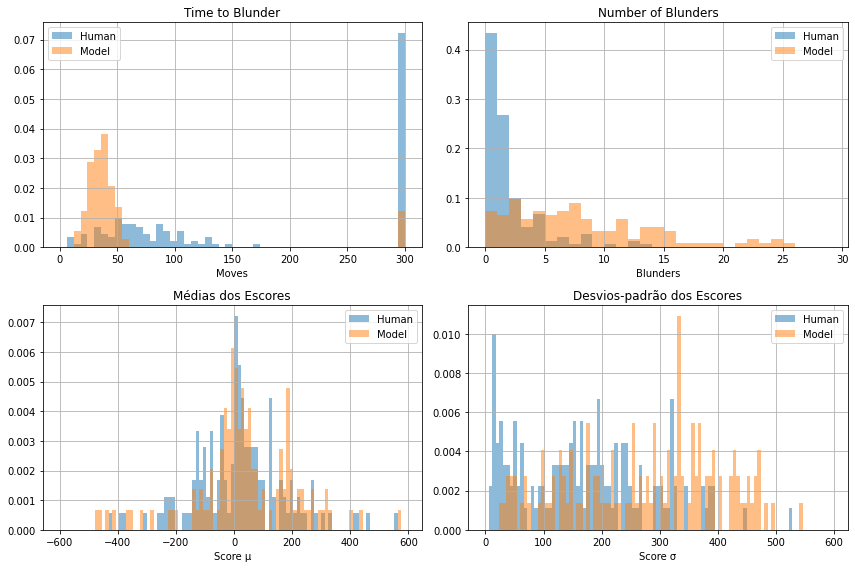

In [62]:
plot_dists(human_df, synthetic_df)

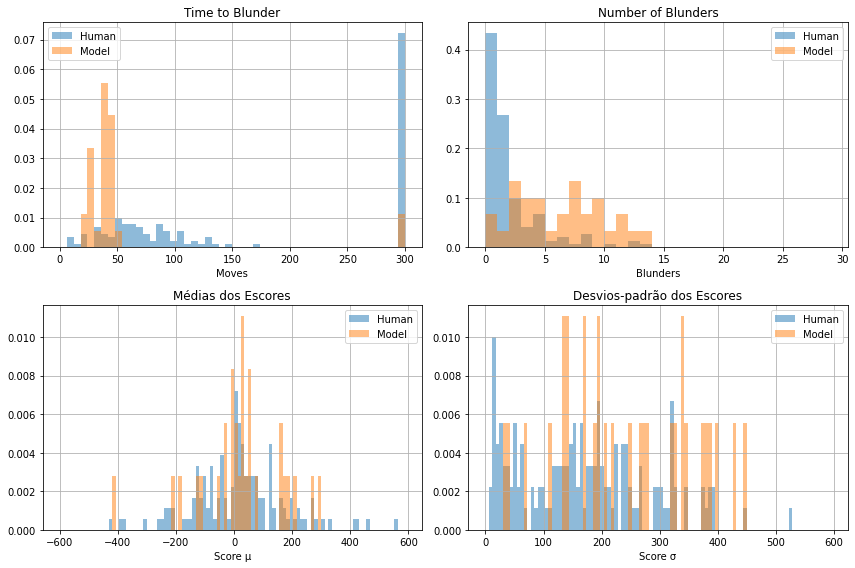

In [64]:
plot_dists(human_df, synthetic_l3_df)

Ordenando as partidas por TTB ou NB:

In [66]:
synthetic_df.sort_values('ttb', ascending=False)

,file,game,la,ttb,nb,score mean,score std
63,lookahead_2_run_4_start_c4.cpgn,c4 Nf6 Nc3 g6 g3 Bg7 Bg2 O-O e4 d6 Nge2 c5 O-...,2,300,0,1.933333,43.793404
73,lookahead_2_run_7_start_Nf3.cpgn,Nf3 Nf6 c4 g6 g3 Bg7 Bg2 O-O O-O d6 d4 Nbd7 N...,2,300,0,-14.066667,45.566386
106,lookahead_3_run_8_start_Nf3.cpgn,Nf3 d5 d4 Nf6 c4 e6 Nc3 Be7 Bg5 h6 Bh4 O-O e3...,3,300,0,19.033333,37.167175
43,lookahead_1_run_7_start_Nf3.cpgn,Nf3 d5 g3 Nf6 Bg2 c6 O-O Bf5 d3 e6 c4 Be7 cxd...,1,300,0,-22.116667,53.014178
105,lookahead_3_run_8_start_c4.cpgn,c4 Nf6 Nc3 g6 g3 Bg7 Bg2 O-O e4 d6 Nge2 c5 O-...,3,300,0,28.883333,32.954055
...,...,...,...,...,...,...,...
119,lookahead_1_run_7.cpgn,e4 c5 Nf3 d6 d4 Nf6 dxc5 Nxe4 cxd6 Nxd6 Nc3 g...,1,19,23,-207.533333,446.520118
15,lookahead_2_run_15.cpgn,e4 e6 d4 d5 Nc3 Bb4 e5 c5 a3 Ba5 b4 cxd4 Nb5 ...,2,17,13,181.183333,469.487681
49,lookahead_1_run_9_start_Nf3.cpgn,Nf3 d5 g3 Nf6 Bg2 e6 O-O Be7 c4 O-O d4 dxc4 Q...,1,15,15,51.800000,263.774449
9,lookahead_1_run_19.cpgn,e4 c5 Nc3 Nc6 Bb5 Nd4 Bc4 e6 Nge2 a6 Nxd4 cxd...,1,14,5,-463.916667,493.407853


In [75]:
synthetic_df.sort_values('ttb', ascending=False).iloc[0]['game']

' c4 Nf6 Nc3 g6 g3 Bg7 Bg2 O-O e4 d6 Nge2 c5 O-O Nc6 d3 a6 h3 Rb8 a4 Bd7 Be3 Ne8 d4 cxd4 Bxd4 Bxd4 Nxd4 Nxd4 Qxd4 b5 axb5 axb5 cxb5 Bxb5 Rfd1 Qb6 Qxb6 Rxb6 Bf1 Bxf1 Rxf1 Nc7 Ra4 Rfb8 Rb1 Rb4 Rxb4 Rxb4 Kf1 Kf8 Ke2 Ke8 Kd3 Kd7 Kc2 Kc6 Kd3 d5 exd5 Nxd5'